<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [3]:
import sys
print(sys.executable)

c:\Users\401809\Documents\S5\data_camp\scmark-classification-predicta\env\Scripts\python.exe


In [4]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [5]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

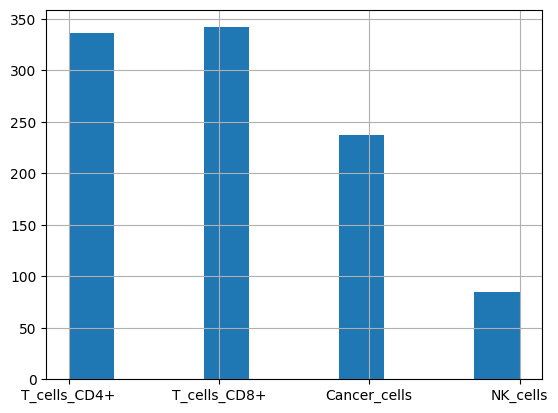

In [6]:
lab_df.label.hist();

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [7]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [8]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [9]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

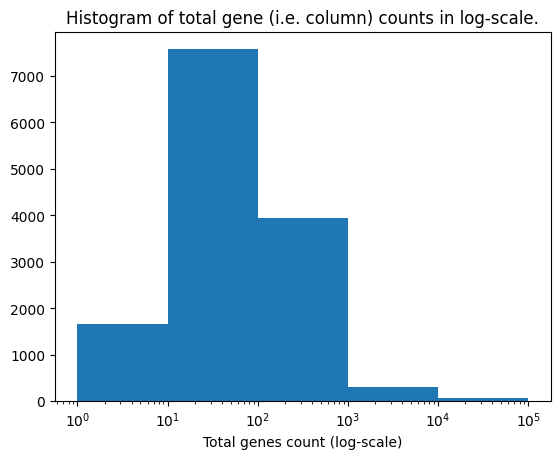

In [10]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

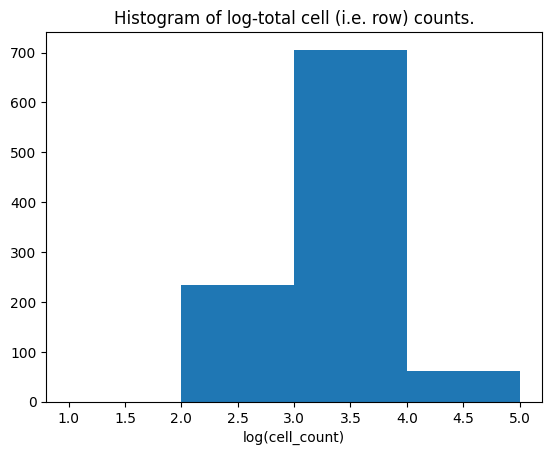

In [11]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [12]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

True

# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [13]:
from sklearn.metrics import balanced_accuracy_score

In [14]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5, n_estimators=100, max_features=3
            ),
        ),
    ]
)

pipe

,steps,"[('Scaler', ...), ('PCA with 50 components', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'


In [16]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.692
Test balanced accuracy : 0.577


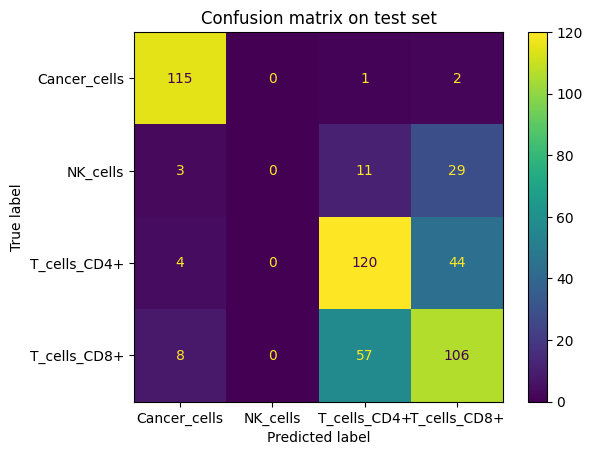

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.
 
**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            RandomForestClassifier(
                max_depth=5, n_estimators=100, 
                max_features=3
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_
        pass

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)


Below is a simplified version of what RAMP does with your submission.

In [19]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [20]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.6887674576270659
Test balanced accuracy: 0.5733968407913754


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [ ]:
!ramp-test --submission starting_kit

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc      time
	train     0.71  2.156162
	valid     0.57  0.140732
	test      0.56  0.097918
CV fold 1
	score  bal_acc      time
	train     0.74  1.413743
	valid     0.58  0.146134
	test      0.59  0.096986
CV fold 2
	score  bal_acc      time
	train     0.71  2.122261
	valid     0.60  0.146318
	test      0.57  0.096218
CV fold 3
	score  bal_acc      time
	train     0.73  2.167345
	valid     0.59  0.154218
	test      0.57  0.099463
CV fold 4
	score  bal_acc      time
	train     0.70  1.898126
	valid     0.58  0.144049
	test      0.57  0.085239
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.72 ± 0.016  2.0 ± 0.29
	valid   0.58 ± 0.01   0.1 ± 0.0
	test   0.57 ± 0.009  0.1 ± 0.01
----------------------------
Bagged scores
----------------------------


We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn

### Preprocessing

In [ ]:
"""
def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]
"""

def remove_highly_correlated_columns(X, seuil=0.95):
    """Remove highly correlated columns."""
    corr = np.corrcoef(X, rowvar=False)
    keep = []
    
    for i in range(X.shape[1]):
        # On garde la colonne seulement si elle n'est pas trop corrélée
        if all(abs(corr[i, j]) < seuil for j in keep):
            keep.append(i)
    
    return X[:, keep]

def _preprocess_X(X_sparse):
    """CPM-like normalization + log1p, standard for scRNA-seq."""
    X = X_sparse.toarray().astype(np.float32)
    counts = X.sum(axis=1)[:, None]
    counts[counts == 0] = 1
    X = X / counts * 1e4
    """Select genes with highest variance."""
    variances = np.var(X, axis=0)
    X_filter = X[:, variances>0.05]
    """Remove highly correlated columns."""
    X_filter = remove_highly_correlated_columns(X_filter)
    return X_filter



### Definition des modèles

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

class Logistique(object):
    def __init__(self):
        # Pipeline: Scaler → PCA → Logistic Regression
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            LogisticRegression(
                max_iter=2000,      # important pour la convergence
                solver="lbfgs",     # bon solver général
                penalty="l2",       # régularisation standard
                multi_class="auto"  # softmax pour multi-classes
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


class Bayes(object):
    def __init__(self):
        # Pipeline: Scaler → PCA → Gaussian Naive Bayes
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            GaussianNB()
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)
    

class XGBoost(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.le = LabelEncoder()
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            #RandomForestClassifier(
            #    max_depth=5, n_estimators=200, 
            #    max_features=10
            #),
            XGBClassifier(
                n_estimators=300,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="multi:softprob",
                eval_metric="mlogloss",
                tree_method="hist",   # rapide et efficace
                random_state=42,
            ),
        )

    def fit(self, X_sparse, y):
        y_enc = self.le.fit_transform(y)
        # Pre-processing
        X = _preprocess_X(X_sparse)

        # PCA
        #self.reducer_ = PCA(n_components=50)
        #X = self.reducer_.fit_transform(X)
        #self.reducer_ = UMAP(n_components=30, random_state=0)
        #X = self.reducer_.fit_transform(X)

        self.pipe.fit(X, y_enc)
        #self.classes_ = self.pipe.classes_
        self.classes_ = self.le.classes_
        
        pass

    def predict_proba(self, X_sparse):

        # Pre-processing
        X = _preprocess_X(X_sparse)

        #X = self.reducer_.fit_transform(X)

        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)
    
    def predict(self, X_sparse):
        proba = self.predict_proba(X_sparse)
        y_enc = np.argmax(proba, axis=1)
        return self.le.inverse_transform(y_enc)

### Logistique

c:\Users\401809\Documents\S5\data_camp\scmark-classification-predicta\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train balanced accuracy: 0.7785030898324242
Test balanced accuracy: 0.6980182542316902


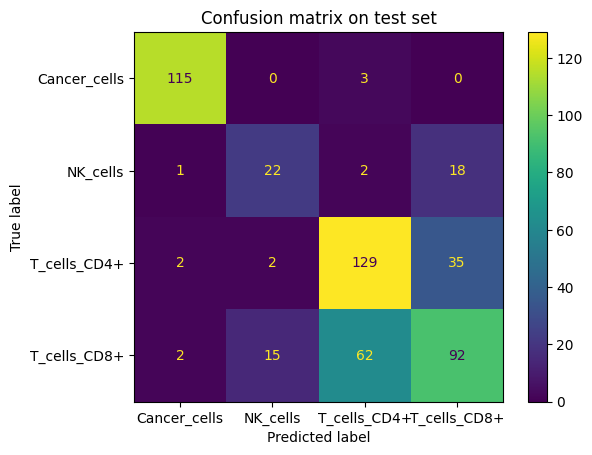

In [ ]:
clf = Logistique()
clf.fit(X_train, y_train)

# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

### Bayes

Train balanced accuracy: 0.45104943265336345
Test balanced accuracy: 0.31503945244467096


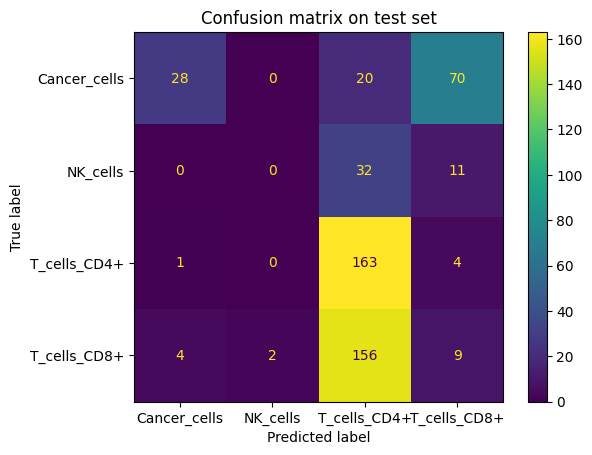

In [ ]:
clf = Bayes()
clf.fit(X_train, y_train)

# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

### XGBoost

Train balanced accuracy: 0.45104943265336345
Test balanced accuracy: 0.31503945244467096


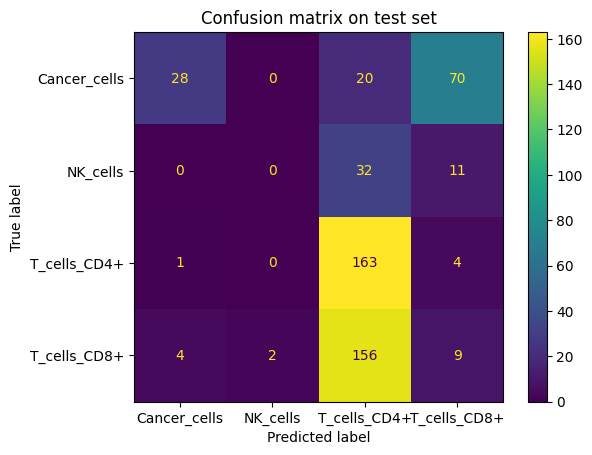

In [ ]:
clf = XGBoost()
clf.fit(X_train, y_train)

# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))